<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font size='5' face='verdana' color='black'><b>Deploy a custom model to the Watson Machine Learning repository using scikit-learn</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
</table>

This notebook demonstrates how to deploy a custom model that uses a non-supported framework to the `Watson Machine Learning (WML)` using a `scikit-learn estimator`. For supported model types (frameworks), refer to this <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html" target="_blank" rel="noopener no referrer">link</a>.

You will deploy the model from the <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/1835c567cd309d54fc797900f79a60f9" target="_blank" rel="noopener no referrer">Use statsmodels to forecast the Consumer Price Index (time series)</a> notebook to the `Watson Machine Learning (WML)` repository. The notebook is in the `Watson Studio` <a href="https://dataplatform.cloud.ibm.com/gallery" target="_blank" rel="noopener no referrer">gallery</a>.

You will learn how to write a `scikit-learn custom estimator`, then deploy it to the `Watson Machine Learning` repository.

The data set, <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/304ff4a1704b967dd29693a4d32ba626" target="_blank" rel="noopener no referrer">Consumer Prices</a>, which is originally sourced from the <a href="http://www.ilo.org/stat/" target="_blank" rel="noopener no referrer">International Labour Organization</a> measures the Consumer Price Index of different countries over a period of time. The **Consumer Price Index (CPI)** is defined as a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services. Forecasting this value is useful because it's a valuable economic indicator used to predict the rate of inflation. It also affects decision making pertaining to income payments.

This notebook uses Python 3.6, `pmdarima`, `statsmodels`, and `watson-machine-learning-client`.

## Learning goals
- Load data as a dataframe
    - Create a time series object
- Explore data
    - Check the stationarity of the time series
        - Seasonal decomposition
        - Dicky-Fuller test
- Prepare data - stationarizing the series
- Optimize the ARIMA parameters and create the model
    - ACF and PACF plots to identify parameters
    - Use grid search for ARIMA
- Train the model
- Deploy the model
- Score the deployed model

## Contents
1. [Load data](#load)
2. [Explore data](#explore)
3. [Prepare data](#prepare)
4. [Model selection](#modelselection)
5. [Deploy the model](#deploy)
6. [Score the model](#score)
7. [Summary and next steps](#summary)

<a id="load"></a>
## 1. Load data 

In this section, you will load the time series data as a dataframe and modify it so that the index is a datetime variable.

The data set contains records of the Consumer Price Indices (CPI) of various countries over time, from 1969 to 2008.

First, install the `numpy` and `pmdarima` packages that are required for interacting with data and modeling. The `wget` package will be used to download the data set.

<div class="alert alert-block alert-warning">
    To simply hide the output of pip install, use <tt>-q</tt> after <tt>!pip install</tt>.
    <br><br>
    If the version of installed <tt>scikit-learn</tt> is <tt>0.20</tt>, install <tt>pmdarima</tt> version <tt>1.2.0</tt>.
    <br><br>
    If the version of installed <tt>scikit-learn</tt> is <tt>0.22</tt>, install <tt>pmdarima</tt> version <tt>1.6.0</tt>.
    <br><br>
    You can check the version of <tt>scikit-learn</tt> by running the following cell.
</div>

In [1]:
try:
    import sklearn
    print('scikit-learn version: {}'.format(sklearn.__version__))
except ImportError:
    print('scikit-learn is not installed.')

scikit-learn version: 0.20.3


In [2]:
# Install packages.
!pip install -q --upgrade pip
!pip install -q numpy # Use --upgrade numpy if numpy is out of date
!pip install -q pmdarima==1.2.0
!pip install -q --upgrade wget

Download the [Consumer Prices](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/304ff4a1704b967dd29693a4d32ba626) from the [Gallery](https://dataplatform.cloud.ibm.com/community?context=analytics) using the following code.

In [3]:
# Download the data set.
from wget import download
from os.path import isfile

price_data = 'Consumer prices.csv'

if not isfile(price_data):
    link_to_data = (
        'https://api.dataplatform.cloud.ibm.com/v2/' +
        'gallery-assets/entries/304ff4a1704b967dd29693a4d32ba626/' +
        'data?accessKey=d1bec8d606656afaa378d73205c1e649')
    
    price_data = download(link_to_data)

print(price_data)

Consumer prices.csv


In [4]:
# Load the data as a dataframe
from pandas import read_csv
from datetime import datetime


def dateparse(dates):
    return datetime.strptime(dates, '%Y')


consumer_prices = read_csv(price_data,
                           parse_dates=['Year'],
                           index_col='Year',
                           date_parser=dateparse,
                           engine='python')
consumer_prices.head()

Country or Area  Scope       Value Value Footnotes
Year                                                         
1991-01-01     Afghanistan  Kabul  143.826616             1,2
1990-01-01     Afghanistan  Kabul  100.000000             1,2
1989-01-01     Afghanistan  Kabul   67.863097             1,2
1988-01-01     Afghanistan  Kabul   39.580269             1,2
1987-01-01     Afghanistan  Kabul   31.038541             1,2

Before the data set is loaded as a dataframe, the *Year* column is converted into a datetime type variable. Each date is unique, which allows the *Year* column to be made the index of the data set so that the dataframe can be used as a time series object.

Now, when you list the dataframe information, you can see the DatatimeIndex and the rest of the columns in the data set. The *Value* column represents the value of the country's Consumer Price Index that year.

In [5]:
consumer_prices.tail()

Country or Area             Scope      Value Value Footnotes
Year                                                                   
1973-01-01        Zimbabwe  Low income group  14.395168               1
1972-01-01        Zimbabwe  Low income group  13.961438               1
1971-01-01        Zimbabwe  Low income group  13.574597               1
1970-01-01        Zimbabwe  Low income group  13.176034               1
1969-01-01        Zimbabwe  Low income group  12.906417               1

In [6]:
consumer_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7187 entries, 1991-01-01 to 1969-01-01
Data columns (total 4 columns):
Country or Area    7187 non-null object
Scope              7187 non-null object
Value              7187 non-null float64
Value Footnotes    3547 non-null object
dtypes: float64(1), object(3)
memory usage: 280.7+ KB


In [7]:
# Distribution of columns.
from pandas import option_context

with option_context('display.max_rows', None):
    for col in consumer_prices:
        print(col, len(consumer_prices[col].value_counts()))

Country or Area 216
Scope 98
Value 6839
Value Footnotes 257


Import the necessary data visualization packages and plot the time series object to observe the several plotted values by country.

In [8]:
from pandas.plotting import register_matplotlib_converters
from matplotlib.pyplot import figure, legend, plot, xlabel, ylabel
register_matplotlib_converters()

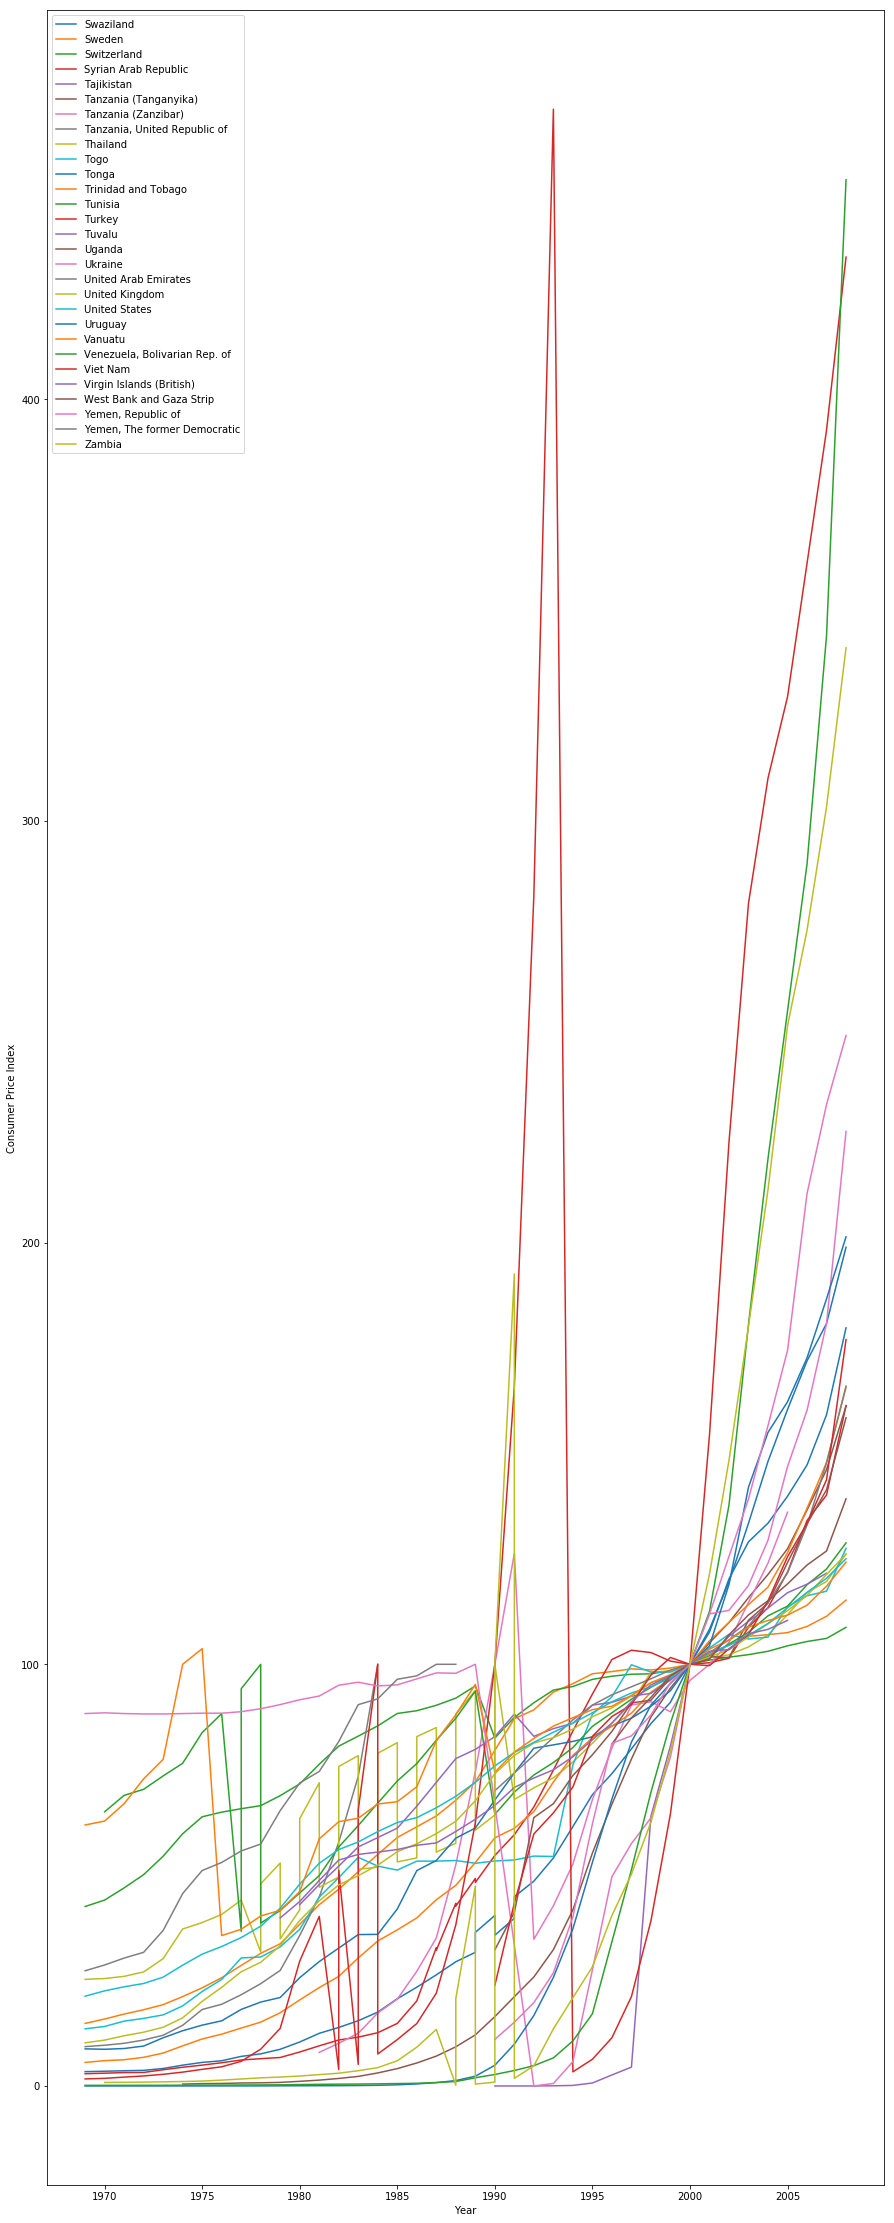

In [9]:
# Plot the data by country.
figure(figsize=(15, 40))

for country in (consumer_prices['Country or Area'].unique()[-30:-1]):
    plot(consumer_prices.loc[(
        consumer_prices['Country or Area'] == country)].index.to_pydatetime(),
        consumer_prices['Value'].loc[consumer_prices['Country or Area'] ==
                                     country],
        label=country)
    xlabel('Year')
    ylabel('Consumer Price Index')
    legend()

First, filter the data to obtain the CPI values for the United States. You can then observe the pattern of the values changing over time (1969-2008) in the country.

In [10]:
# CPI values in the United States.
us_consumer_prices = consumer_prices[[
    'Value'
]].loc[consumer_prices['Country or Area'] == 'United States']
us_consumer_prices = us_consumer_prices.sort_index()
us_consumer_prices.head()

Value
Year                 
1969-01-01  21.293935
1970-01-01  22.554505
1971-01-01  23.524174
1972-01-01  24.299910
1973-01-01  25.812594

In [11]:
# Plot time series data.
figure(figsize=(15, 8))
xlabel('Year')
ylabel('Consumer Price Index')
plot(us_consumer_prices.index.to_pydatetime(), us_consumer_prices['Value']);

<a id="explore"></a>
## 2. Explore data

In this section, you will explore the data to learn more about the stationarity of the series and determine the steps to take for data preparation.

### 2.1 Checking stationarity of time series

Check the stationarity of the time series, since many models assume that the series is stationary. A time series is stationary when the mean, variance, and covariance of the data are constant and not dependent on time.

#### Seasonal Decomposition

You will use the `statsmodels` package to plot and model the time series data.

Decompose the time series to observe the trend and seasonality in the data.

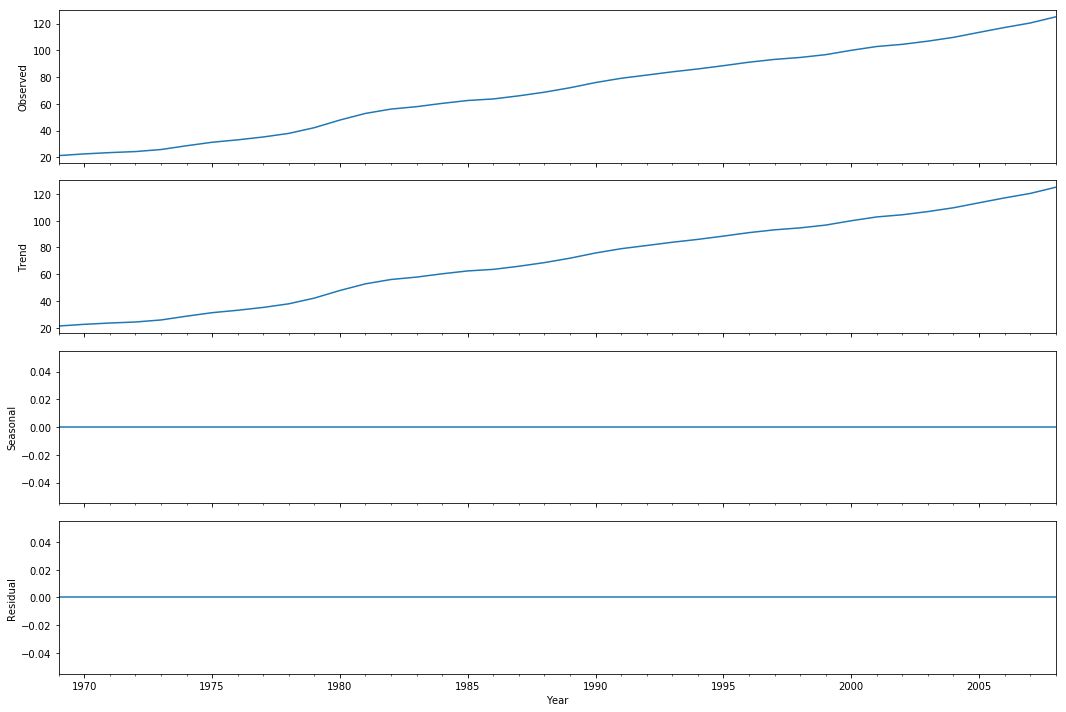

In [12]:
# Decomposition of the time series data.
from pylab import rcParams
from statsmodels.api import tsa

rcParams['figure.figsize'] = 15, 10
decomposition = tsa.seasonal_decompose(us_consumer_prices['Value'],
                                       model='additive')
fig = decomposition.plot()
xlabel('Year');

As you can see, the trend is changing based on time, so you can infer that the series is not stationary. You can also use another method, called the Dicky-Fuller test, to confirm this observation.

#### Dicky-Fuller Test

In [13]:
# Augmented Dicky-Fuller test.
from pandas import Series
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(us_consumer_prices['Value'], autolag='AIC')
dfoutput = Series(dftest[0:4],
                  index=[
                      'Test Statistic', 'p-value', 'Number of Lags Used',
                      'Number of Observations Used'
                  ])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
    
print(dfoutput)

Test Statistic                  0.640969
p-value                         0.988583
Number of Lags Used             2.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


You can use the Dicky-Fuller test to check the stationarity of the time series data.

The null hypothesis $H_{o}$ assumes that the time series is dependent on time (that it is non-stationary). Since the `Test Statistic` is larger than the `Critical Values`, we cannot reject the null hypothesis and understand that the series is **non-stationary**.

<a id="prepare"></a>
## 3. Prepare data

### 3.1 ACF & PACF plots

A common tool used to forecast time series data is the `ARIMA` (**A**uto **R**egressive **I**ntegrated **M**oving **A**verage) model. The model has 3 parameters 
- `p` - the parameter associated with the Auto-Regressive part of the ARIMA model. You can use the **PACF (partial autocorrelation function)** plot to find the optimal value.
- `d` - the parameter associated with the Integration part of the ARIMA model. This is the **order of difference**, or the number of times the time series is differenced in order to stationarize the series.
- `q` - the parameter associated with the Moving Average part of the ARIMA model. You can use the **ACF (autocorrelation function)** plot to find the optimal value.

Here are the ACF and PACF plots of the original time series data.

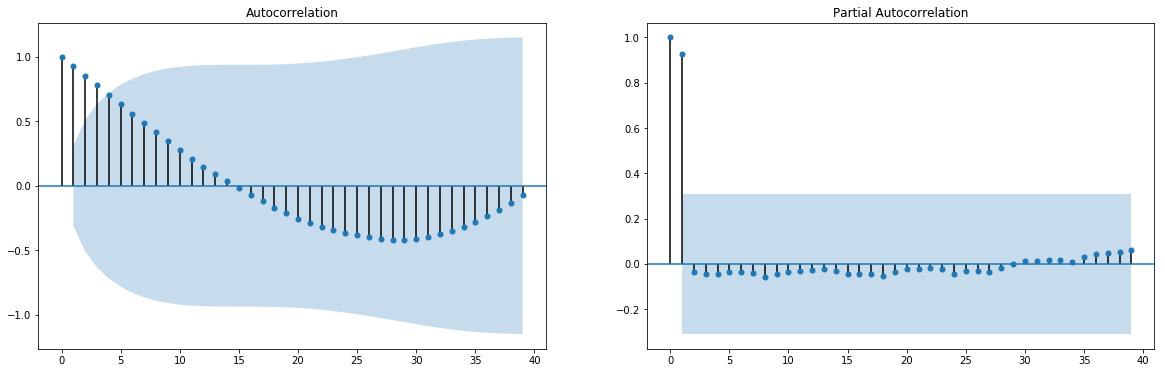

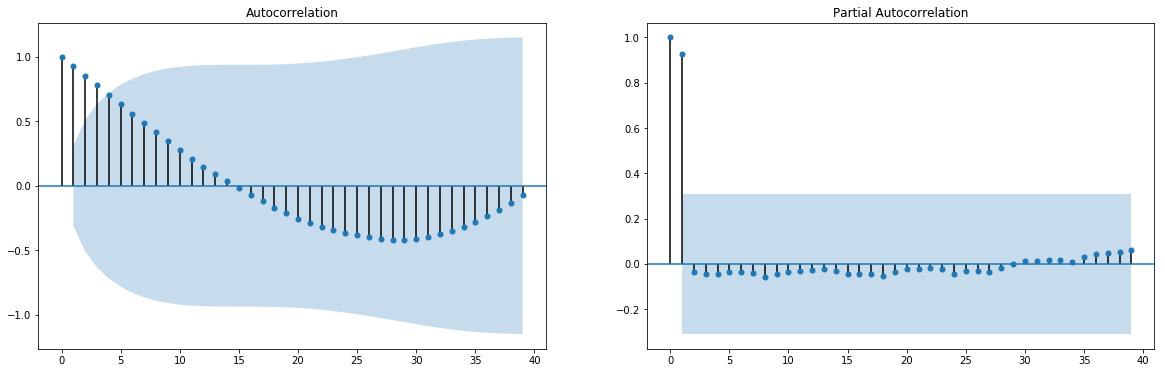

In [14]:
# Visualize the ACF and PACF plots.
from matplotlib.pyplot import subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f, (ax1, ax2) = subplots(1, 2, figsize=(20, 6))
plot_acf(us_consumer_prices['Value'], ax=ax1)
plot_pacf(us_consumer_prices['Value'], ax=ax2, method='ywmle')

Since the series is not stationary, you will first use differencing before finding the parameters for the model.

### 3.2 Stationarizing the time series data

**Differencing** is used to remove the non-stationarity caused by the trend. The number of differences needed to remove stationarity determines the parameter `d`, for the Integration component of the ARIMA model. Run the following code to difference the data twice and plot the resulting values.

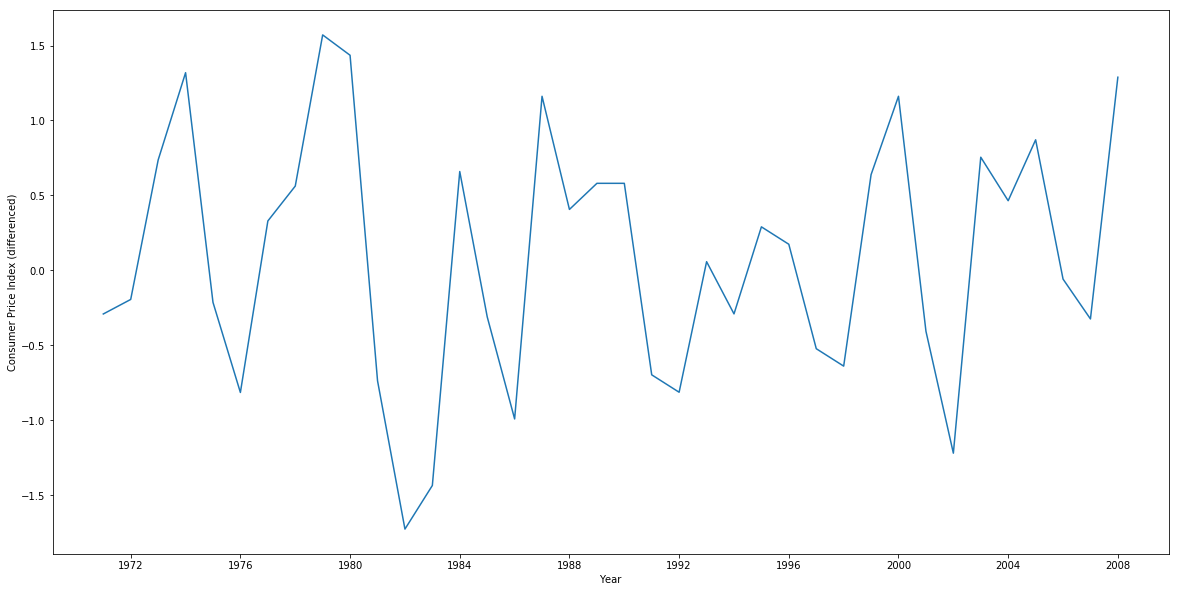

In [15]:
# Differencing - remove non-stationarity.
figure(figsize=(20, 10))
us_consumer_prices_dif = (((
    us_consumer_prices.diff()).dropna()).diff()).dropna()

xlabel('Year')
ylabel('Consumer Price Index (differenced)')
plot(us_consumer_prices_dif['Value']);

The time series data has been differenced twice to remove stationarity. You can observe the trend of the modified data using the seasonal decomposition method once again.

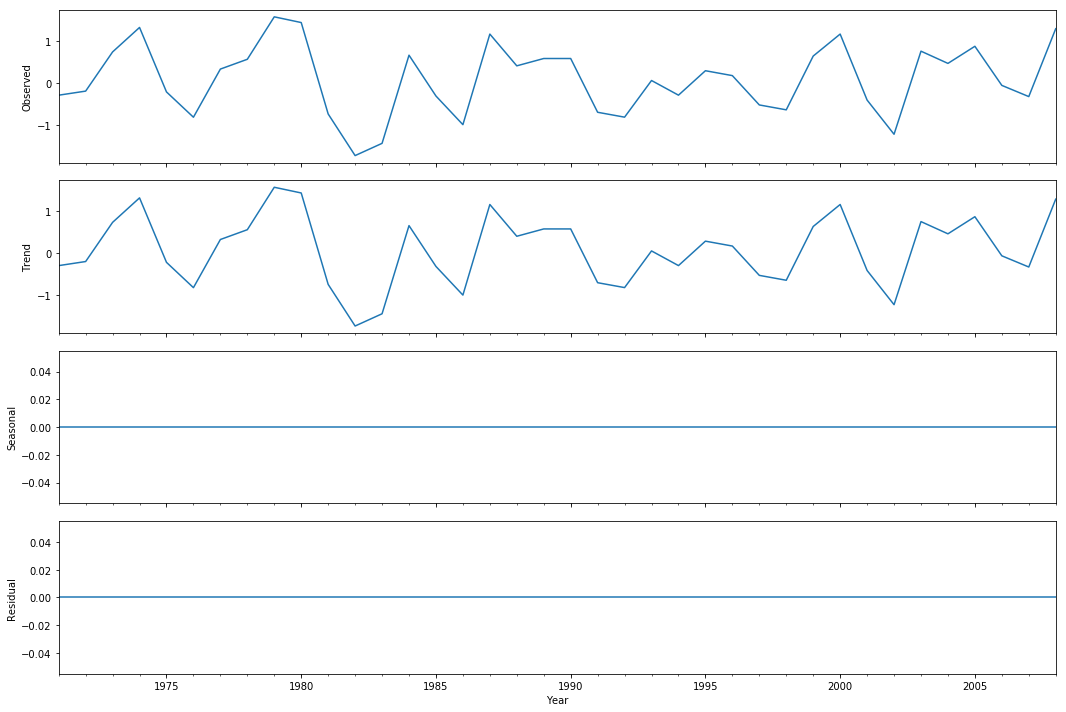

In [16]:
# Decomposition of stationarized time series.
rcParams['figure.figsize'] = 15, 10
decomposition = tsa.seasonal_decompose(us_consumer_prices_dif['Value'],
                                       model='additive')
fig = decomposition.plot()
xlabel('Year');

From the plot, you can see that there is no observable trend or seasonality in the differenced time series data. Once again, you can use the Augmented Dicky-Fuller test to confirm that the stationarity of the data as well.

In [17]:
# Augmented Dicky-Fuller test.
dftest = adfuller(us_consumer_prices_dif['Value'], autolag='AIC')
dfoutput = Series(dftest[0:4],
                  index=[
                      'Test Statistic', 'p-value', 'Number of Lags Used',
                      'Number of Observations Used'
                  ])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
    
print(dfoutput)

Test Statistic                -5.709087e+00
p-value                        7.370726e-07
Number of Lags Used            1.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


Since the `Test Statistic` here is less than the `Critical Values`, we can reject the null hypothesis and we can assume that the series is stationary. As you can see from the decomposition plot and the Dicky-Fuller test, the stationarity has been removed.

<a id="modelselection"></a>
## 4. Model Selection

Now, you can run the code below to plot the ACF and PACF plots of the modified stationary data.

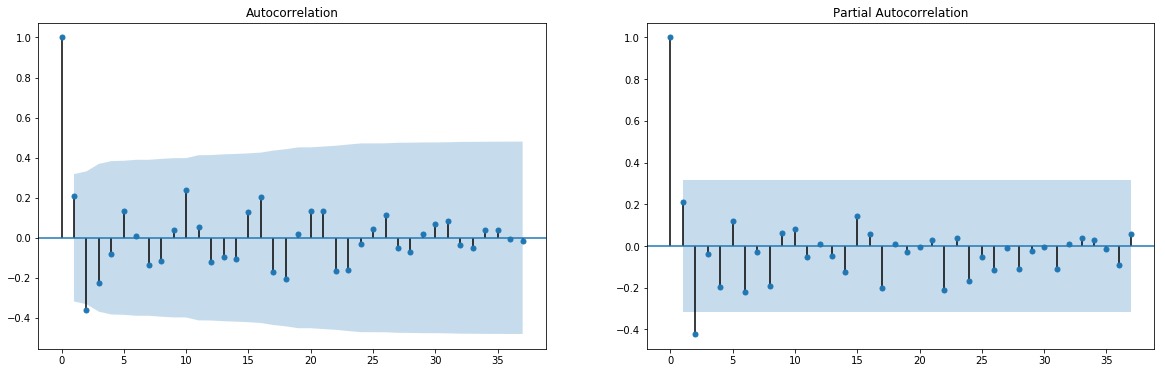

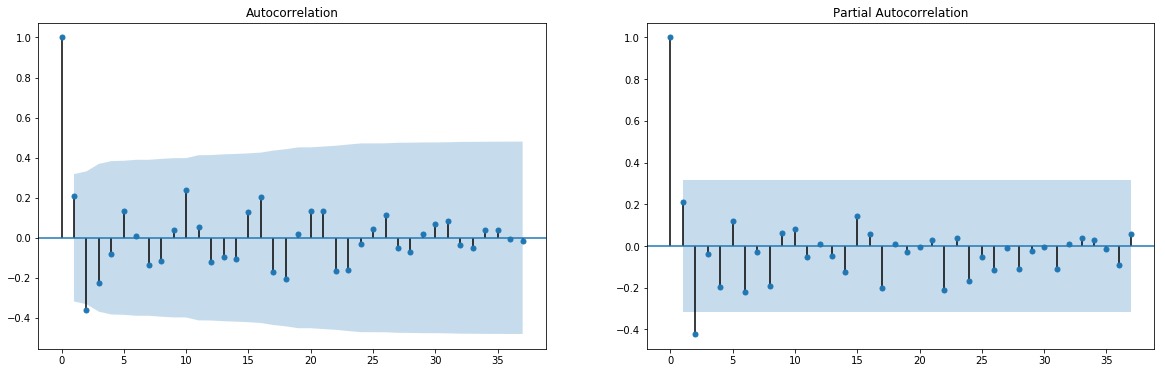

In [18]:
# Visualize the ACF and PACF plots of the stationarized series.
f, (ax1, ax2) = subplots(1, 2, figsize = (20, 6))
plot_acf(us_consumer_prices_dif['Value'], ax = ax1)
plot_pacf(us_consumer_prices_dif['Value'], ax = ax2, method='ywmle')

### 4.1 Grid Search

To check the optimal values for the ARIMA parameters, you can perform grid search using the `auto_arima` module below.

In [19]:
# Import auto-arima - grid search for ARIMA.
from pmdarima.arima import auto_arima

Run the following code to compare the various combinations of the ARIMA parameters, as well as the seasonal parameters.

In [20]:
# Perform grid search for the ARIMA model.
stepwise_model = auto_arima(us_consumer_prices[:'2000'],
                            start_p=0,
                            start_q=0,
                            max_p=5,
                            max_q=5,
                            seasonal=False,
                            d=2,
                            D=0,
                            trace=True,
                            suppress_warnings=True,
                            error_action='ignore',
                            stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 2, 0); AIC=78.442, BIC=81.245, Fit time=0.011 seconds
Fit ARIMA: order=(1, 2, 0); AIC=77.673, BIC=81.876, Fit time=0.039 seconds
Fit ARIMA: order=(0, 2, 1); AIC=71.611, BIC=75.815, Fit time=0.050 seconds
Fit ARIMA: order=(1, 2, 1); AIC=72.600, BIC=78.205, Fit time=0.059 seconds
Fit ARIMA: order=(0, 2, 2); AIC=72.036, BIC=77.640, Fit time=0.065 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.242 seconds
71.61111442190239


The parameter set with the lowest `AIC` value (criteria that measures the model) is a good choice to fit the model. As you can see, the lowest `AIC` value is about 353.6, so the optimal parameters are `order = (0, 2, 1)`.

### 4.2 Install the custom scikit-learn estimator <a id="custom"></a>

<div class="alert-block alert-info"><br>
    &nbsp;&nbsp;&nbsp;&nbsp;Documentation on how to package a custom <tt>scikit-learn transformer</tt> using <tt>watson-machine-learning-client</tt> can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-custom_libs_scikit_learn.html?audience=wdp&linkInPage=true" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>

The same method in the above link can also be applied to packaging a custom `scikit-learn custom estimator`.

The `scikit-learn custom estimator` that wraps the `statsmodels` model looks like the following and is included in `sklearn_arima-0.1.zip` file that will be downloaded in this subsection.

Download the packaged `custom estimator` package.

In [21]:
filename = 'sklearn_arima-0.1.zip'

if not isfile(filename):
    filename = download(
        'https://github.com/IBMDataScience/sample-notebooks/raw/master/' +
        'Files/sklearn_arima-0.1.zip'
    )

print(filename)

sklearn_arima-0.1.zip


Install the downloaded `custom estimator` package that is compressed in `.zip` format using the `pip install` command.

In [22]:
!pip install sklearn_arima-0.1.zip

Processing ./sklearn_arima-0.1.zip
  Created wheel for sklearn-arima: filename=sklearn_arima-0.1-py3-none-any.whl size=2411 sha256=c7b0c79dc11db9977fbd9be0c50c072f7cdb670b2064cf90e887fe3c2373f49c
  Stored in directory: /home/dsxuser/.cache/pip/wheels/45/18/22/bef9c05fba970a12a67621d210352b92ef35658942b13a530c
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=b66134902aa1efd9a3a98c64c6281b49c27b24e1d07a239c50ff57d7f8df2991
  Stored in directory: /home/dsxuser/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn-arima sklearn


### 4.3 Build the model <a id="build"></a>

Import required modules. The `SklearnArima` module is the `custom estimator` you installed locally in section [4.2 Install the custom scikit-learn estimator](#custom).

A `scikit-learn` pipeline consists of `transformer(s)` and a final `estimator`. You can check the details of the `scikit-learn` pipeline <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline" target="_blank" rel="noopener no referrer">here</a>.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn_arima.arima import SklearnArima

In [24]:
pipeline = Pipeline(
    [
        ('arima', SklearnArima(us_consumer_prices[:'2000'], order=(0, 2, 1)))
    ]
)

Train the model.

In [25]:
pipeline.fit(us_consumer_prices[:'2000'])

Pipeline(memory=None,
     steps=[('arima', SklearnArima(X=                 Value
1969-01-01   21.293935
1970-01-01   22.554505
1971-01-01   23.524174
1972-01-01   24.299910
1973-01-01   25.812594
1974-01-01   28.644028
1975-01-01   31.262134
1976-01-01   33.065719
1977-01-01   35.198991
1978-01-01   37.894672
1979-01-01   42.161216
1980-01-01   47.862871...1.114983
1997-01-01   93.205575
1998-01-01   94.657375
1999-01-01   96.747967
2000-01-01  100.000000,
       alpha=0.05, order=(0, 2, 1), steps=8))])

Test the model.

- The first array is the out of sample forecasts.
- The second array is the standard error of the forecasts.
- The third array is a 2D array of the confidence interval for the forecast.

Refer to this <a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html#statsmodels.tsa.arima_model.ARIMAResults.forecast" target="_blank" rel="noopener no referrer">link</a> on the return values of the `predict` method.

In [26]:
pipeline.predict(us_consumer_prices[:'2000'])

(array([103.61841519, 107.30849956, 111.07025313, 114.90367589,
        118.80876783, 122.78552896, 126.83395929, 130.9540588 ]),
 array([ 0.71236753,  2.08408232,  3.82279395,  5.86723868,  8.17811507,
        10.72804463, 13.49661345, 16.46786035]),
 array([[102.22220049, 105.01462988],
        [103.22377328, 111.39322585],
        [103.57771466, 118.5627916 ],
        [103.40409939, 126.40325238],
        [102.77995683, 134.83757883],
        [101.75894787, 143.81211006],
        [100.381083  , 153.28683557],
        [ 98.67764562, 163.23047199]]))

### 4.4 Deploy the custom scikit-learn estimator <a id="custom_deploy"></a>

Import the `WatsonMachineLearningAPIClient` module.

In [27]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

<div class="alert-block alert-info"><br>
    &nbsp;&nbsp;&nbsp;&nbsp;The <tt>watson-machine-learning-client</tt> documentation can be found <a href="https://wml-api-pyclient-dev.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;Documentation on how to obtain your Watson Machine Learning (WML) service instance credentials can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-get-wml-credentials.html?audience=wdp&linkInPage=true" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>

You need your `Watson Machine Learning (WML)` credentials to instantiate a `WatsonMachineLearningAPIClient` object.

<div class="alert alert-block alert-warning">
    Enter your WML service instance credentials in the following cell.
</div>

In [28]:
wml_credentials = {
    'apikey': '****',
    'iam_apikey_description': '****',
    'iam_apikey_name': '****',
    'iam_role_crn': '****',
    'iam_serviceid_crn': '****',
    'instance_id': '****',
    'password': '****',
    'url': '****',
    'username': '****'
}

In [29]:
# The code was removed by Watson Studio for sharing.

In [30]:
client = WatsonMachineLearningAPIClient(wml_credentials)

Store the downloaded `custom package` in the Watson Machine Learning repository.

<div class="alert alert-block alert-warning">
    &bull;&nbsp;For <tt>client.runtimes.LibraryMetaNames.NAME</tt>, specify the value passed in the name parameter of the <tt>setup()</tt> function in the <tt>setup.py</tt> file. <br><br>
    &bull;&nbsp;For <tt>client.runtimes.LibraryMetaNames.FILEPATH</tt>, specify the <tt>.zip</tt> file name of your custom package. <br><br>
    &bull;&nbsp;The identifier of the stored package, <tt>custom_package_uid</tt>, is required for the next step.
</div>

In [31]:
custom_estimator_meta = {
    client.runtimes.LibraryMetaNames.NAME: 'sklearn_arima',
    client.runtimes.LibraryMetaNames.DESCRIPTION:
    'ARIMA model for sklearn pipeline',
    client.runtimes.LibraryMetaNames.FILEPATH: 'sklearn_arima-0.1.zip',
    client.runtimes.LibraryMetaNames.VERSION: '0.1',
    client.runtimes.LibraryMetaNames.PLATFORM: {
        'name': 'python',
        'versions': ['3.6']
    }
}
custom_estimator_details = client.runtimes.store_library(custom_estimator_meta)
custom_estimator_uid = client.runtimes.get_library_uid(
    custom_estimator_details)
print('Custom Estimator UID: {}'.format(custom_estimator_uid))

Custom Estimator UID: e4e13ef7-f328-4a7a-8a1e-c3bd51597199


In [32]:
client.runtimes.list_libraries()

------------------------------------  -------------  -------  ------------------------  -------------  -----------------
GUID                                  NAME           VERSION  CREATED                   PLATFORM NAME  PLATFORM VERSIONS
e4e13ef7-f328-4a7a-8a1e-c3bd51597199  sklearn_arima  0.1      2020-05-09T18:06:35.147Z  python         ['3.6']
------------------------------------  -------------  -------  ------------------------  -------------  -----------------


Check the details of the `custom package` metadata.

In [33]:
custom_estimator_details

{'metadata': {'guid': 'e4e13ef7-f328-4a7a-8a1e-c3bd51597199',
  'url': 'https://us-south.ml.cloud.ibm.com/v4/libraries/e4e13ef7-f328-4a7a-8a1e-c3bd51597199',
  'created_at': '2020-05-09T18:06:35.147Z',
  'modified_at': '2020-05-09T18:06:36.688Z'},
 'entity': {'name': 'sklearn_arima',
  'description': 'ARIMA model for sklearn pipeline',
  'version': '0.1',
  'platform': {'name': 'python', 'versions': ['3.6']}}}

Create a `runtime resource` object that references your stored custom package.

In [34]:
runtimes_meta = {
    client.runtimes.ConfigurationMetaNames.NAME: 'sklearn_arima_model',
    client.runtimes.ConfigurationMetaNames.DESCRIPTION:
    'scikit-learn ARIMA model',
    client.runtimes.ConfigurationMetaNames.PLATFORM: {
        'name': 'python',
        'version': '3.6'
    },
    client.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS:
    [custom_estimator_uid]
}

Store the `runtime resource` object in the Watson Machine Learning (WML) repository.

In [35]:
runtime_details = client.runtimes.store(runtimes_meta)
runtime_details

{'metadata': {'guid': 'b81845de-8c4e-4333-9d95-45105a8cde11',
  'url': 'https://us-south.ml.cloud.ibm.com/v4/runtimes/b81845de-8c4e-4333-9d95-45105a8cde11',
  'created_at': '2020-05-09T18:06:38.358Z'},
 'entity': {'name': 'sklearn_arima_model',
  'description': 'scikit-learn ARIMA model',
  'custom_libraries': [{'name': 'sklearn_arima',
    'version': '0.1',
    'url': 'https://private.us-south.ml.cloud.ibm.com/v4/libraries/e4e13ef7-f328-4a7a-8a1e-c3bd51597199'}],
  'content_url': 'https://private.us-south.ml.cloud.ibm.com/v4/runtimes/b81845de-8c4e-4333-9d95-45105a8cde11/content',
  'platform': {'name': 'python', 'version': '3.6'}}}

You need the identifier of the runtime resource object, `custom_runtime_uid`, for the next step. 

In [36]:
runtime_url = client.runtimes.get_url(runtime_details)
runtime_uid = client.runtimes.get_uid(runtime_details)
print('Runtimes URL: {}'.format(runtime_url))
print('Runtimes UID: {}'.format(runtime_uid))

Runtimes URL: https://us-south.ml.cloud.ibm.com/v4/runtimes/b81845de-8c4e-4333-9d95-45105a8cde11
Runtimes UID: b81845de-8c4e-4333-9d95-45105a8cde11


Store your trained model in the Watson Machine Learning (WML) repository referencing your stored runtime resource in meta data.

In [37]:
model_props = {
    client.repository.ModelMetaNames.NAME:
    'Custom ARIMA estimator for sklearn pipeline',
    client.repository.ModelMetaNames.RUNTIME_UID: runtime_uid
}

In [38]:
published_model = client.repository.store_model(model=pipeline, meta_props=model_props)

Print the details of the trained model.

In [39]:
from json import dumps

In [40]:
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(dumps(model_details, indent=2))

{
  "metadata": {
    "guid": "f03f08d0-3a4a-450e-8995-260dd16341e1",
    "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/f03f08d0-3a4a-450e-8995-260dd16341e1",
    "created_at": "2020-05-09T18:06:39.266Z",
    "modified_at": "2020-05-09T18:06:39.329Z"
  },
  "entity": {
    "runtime_environment": "python-3.6",
    "learning_configuration_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/f03f08d0-3a4a-450e-8995-260dd16341e1/learning_configuration",
    "name": "Custom ARIMA estimator for sklearn pipeline",
    "learning_iterations_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/f03f08d0-3a4a-450e-8995-260dd16341e1/learning_iterations",
    "feedback_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/f03f08d0-3a4a-450e-8995-260dd16341e1/fe

### 4.5 Forecasting <a id="forecast"></a>

Now, that you've built the model, you can use it to predict the Consumer Price Index for years 2001-08 and compare the predictions with the observed numbers. Run the code below to plot the observed values alongside the predicted values with a 95% confidence interval.

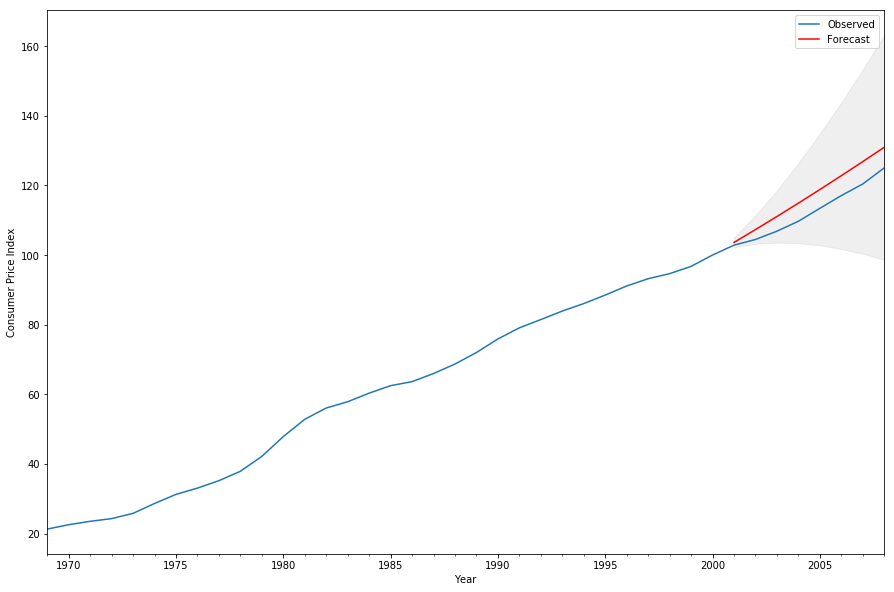

In [41]:
from pandas import DataFrame

ax = us_consumer_prices['1969':'2008'].plot(label='Observed')
forecast, stderr, conf_int = pipeline.predict(us_consumer_prices[:'2000'])
forecast = DataFrame(forecast).set_index(us_consumer_prices['2001':].index)
forecast.plot(ax=ax, style='r', label='Forecast')

# Calculate and visualize the 95% confidence interval.
ax.fill_between(us_consumer_prices['2001':].index,
                conf_int[:, 0],
                conf_int[:, 1],
                color='dimgray',
                alpha=0.1)

# Add the labels to the plot.
legend(('Observed', 'Forecast'))
xlabel('Year')
ylabel('Consumer Price Index');

In the plot above, you can observe how the predicted values (in red) measure up to the observed values (in blue) during the years 2001-08. As you can see, the time series model built in this notebook does a good job of predicting the Consumer Price Index in the United States close to the observed numbers.

## 5. Deploy the model <a id="deploy"></a>

Deploy the model to the Watson Machine Learning repository.

In [42]:
sklearn_arima_deployment = client.deployments.create(
    published_model_uid, name='sklearn_pipeline_arima')



#######################################################################################

Synchronous deployment creation for uid: 'f03f08d0-3a4a-450e-8995-260dd16341e1' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS......
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='7d92c8d5-c921-4448-aeca-98887ac2794a'
------------------------------------------------------------------------------------------------




## 6. Score the model <a id="score"></a>

### 6.1 Scoring

Get the url of the `scoring endpoint`.

In [43]:
scoring_endpoint = client.deployments.get_scoring_url(sklearn_arima_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/deployments/7d92c8d5-c921-4448-aeca-98887ac2794a/online


The payload that is passed to the `scoring endpoint` is the same as the one used for testing the trained model in section [4.3 Build the model](#build).

In [44]:
us_consumer_prices[:'2000'].values.reshape(1, -1).tolist()

[[21.29393521,
  22.55450514,
  23.52417432,
  24.29990967,
  25.81259359,
  28.6440276,
  31.26213438,
  33.06571906,
  35.19899126,
  37.89467158,
  42.16121597,
  47.86287075,
  52.82757696,
  56.06627202,
  57.86985670000001,
  60.33281642,
  62.485482,
  63.64692218,
  65.96980256,
  68.69918699,
  72.00929152,
  75.90011614,
  79.09407666,
  81.47502904,
  83.91405343,
  86.06271777,
  88.50174216,
  91.11498258,
  93.20557491,
  94.65737515,
  96.74796748,
  100.0]]

In [45]:
scoring_payload = {
    'values': us_consumer_prices[:'2000'].values.reshape(1, -1).tolist()
}

Get the prediction results of the deployed model through the `scoring endpoint`.

In [46]:
predictions = client.deployments.score(scoring_endpoint, scoring_payload)

In [47]:
predictions['values']

[[[103.61841518710672,
   107.30849956368732,
   111.0702531297418,
   114.90367588527016,
   118.8087678302724,
   122.78552896474852,
   126.83395928869852,
   130.9540588021224]],
 [[0.7123675252174944,
   2.084082319757026,
   3.82279395234582,
   5.867238675830576,
   8.178115068596716,
   10.728044626990753,
   13.4966134544235,
   16.46786034862888]],
 [[[102.2222004939245, 105.01462988028894],
   [103.22377327614686, 111.39322585122778],
   [103.57771466282647, 118.56279159665714],
   [103.40409939194176, 126.40325237859857],
   [102.77995683439852, 134.83757882614628],
   [101.75894787130821, 143.81211005818884],
   [100.38108300476974, 153.2868355726273],
   [98.67764561637458, 163.23047198787023]]]]

### 6.2 Forecasting

Plot the same graph in section [4.4 Forecasting](#forecast) to see if the scored results are the same as the one predicted locally.

Prepare data to plot the forecast results.

In [48]:
from numpy import array

forecast = array(predictions['values'][0][0])
conf_int = array(predictions['values'][2][0])
print(forecast)
print(conf_int)

[103.61841519 107.30849956 111.07025313 114.90367589 118.80876783
 122.78552896 126.83395929 130.9540588 ]
[[102.22220049 105.01462988]
 [103.22377328 111.39322585]
 [103.57771466 118.5627916 ]
 [103.40409939 126.40325238]
 [102.77995683 134.83757883]
 [101.75894787 143.81211006]
 [100.381083   153.28683557]
 [ 98.67764562 163.23047199]]


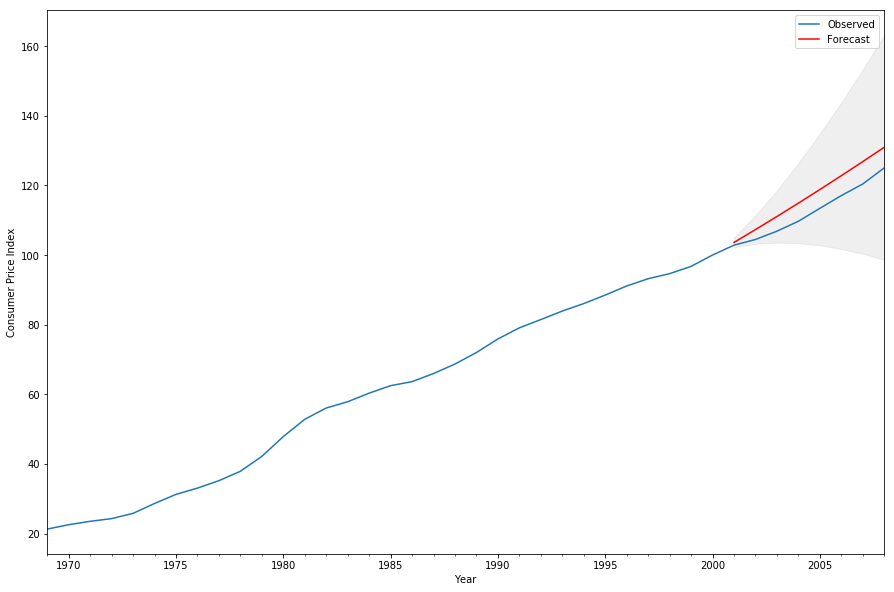

In [49]:
ax = us_consumer_prices['1969':'2008'].plot(label='Observed')
forecast = DataFrame(forecast).set_index(us_consumer_prices['2001':].index)
forecast.plot(ax=ax, style='r', label='Forecast')

# Calculate and visualize the 95% confidence interval.
ax.fill_between(us_consumer_prices['2001':].index,
                conf_int[:, 0],
                conf_int[:, 1],
                color='dimgray',
                alpha=0.1)

# Add the labels to the plot.
legend(('Observed', 'Forecast'))
xlabel('Year')
ylabel('Consumer Price Index');

The generated graph and the one in section [4.4 Forecasting](#forecast) are the same.

<a id="summary"></a>
## 7. Summary and next steps

You successfully completed this notebook and learned how to create a Time Series model. You can now analyze a time series data to check its stationarity, stationarize the series if necessary, and find the optimal parameters for the ARIMA model. You've learned how to use this model to forecast data with a confidence interval.

You also learned how to deploy a non-supported model using a `custom scikit-learn estimator`.


### Resources <a id="resources"></a>

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
<ul>
 <li><a href="https://wml-api-pyclient-dev.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
</ul>

<h4> IBM Samples</h4>
<ul>
 <li><a href="https://dataplatform.cloud.ibm.com/gallery" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
</ul>

<h4> Others</h4>
<ul>
 <li><a href="https://www.python.org" target="_blank" rel="noopener noreferrer">Official Python website</a></li>
 <li><a href="https://scikit-learn.org/stable/modules/compose.html" target="_blank" rel="noopener noreferrer">Scikit-learn: Pipeline</a></li>   
 <li><a href="http://alkaline-ml.com/pmdarima/" target="_blank" rel="noopener noreferrer">Official pmdarima website</a></li>
 <li><a href="https://pandas.pydata.org/" target="_blank" rel="noopener noreferrer">Official pandas website</a></li>
 <li><a href="https://www.statsmodels.org/stable/tsa.html" target="_blank" rel="noopener noreferrer">Statsmodels: Time Series analysis (tsa)</a></li>
 <li><a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
</ul>
 </div>

### Data citations

UNData: Consumer prices, general indices (2000=100). (2010). Retrieved from [http://data.un.org/](http://data.un.org/Data.aspx?d=LABORSTA&f=tableCode%3a7A).

Consumer Price Index: U.S. Bureau Of Labor Statistics. Retrieved from https://www.bls.gov/cpi/.



### Authors

**Ananya Kaushik** is a Data Scientist at IBM.  
**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who contributes to Watson Studio in order to democratize data science.

Copyright © 2019-2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>